In [1]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [50]:
class LSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wix =  Parameter(torch.Tensor(hiddensz,inputsz)) ##################### TO DO #####################
        self.Wih = Parameter(torch.Tensor(hiddensz,hiddensz)) ##################### TO DO #####################
        self.bi = Parameter(torch.Tensor(hiddensz,1)) ##################### TO DO #####################
        
        #forget gate
        ##################### TO DO #####################
        self.Wfx = Parameter(torch.Tensor(hiddensz,inputsz))
        self.Wfh = Parameter(torch.Tensor(hiddensz,hiddensz))
        self.bf = Parameter(torch.Tensor(hiddensz,1)) 
        #c gate
        ##################### TO DO #####################
        self.Wcx = Parameter(torch.Tensor(hiddensz,inputsz))
        self.Wch = Parameter(torch.Tensor(hiddensz,hiddensz))
        self.bc = Parameter(torch.Tensor(hiddensz,1)) 
        #output gate
        ##################### TO DO #####################
        self.Wox = Parameter(torch.Tensor(hiddensz,inputsz))
        self.Woh = Parameter(torch.Tensor(hiddensz,hiddensz))
        self.bo = Parameter(torch.Tensor(hiddensz,1)) 
        
        #paramter initialization
        for p in self.parameters():  
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
        else:
            ht,ct = initstates
        for t in range(m):
            xt = x[t,:].reshape(-1,1)
            it =   torch.sigmoid(self.Wix@xt+self.Wih@ht+self.bi)
            ft =   torch.sigmoid(self.Wfx@xt+self.Wfh@ht+self.bf)
            gt =   torch.tanh(self.Wcx@xt+self.Wch@ht+self.bc)
            ot =   torch.sigmoid(self.Wox@xt+self.Woh@ht+self.bo)
            ct =   ft*ct+it*gt
            ht =   ot*torch.tanh(ct)
            hidden_seq.append(ht.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [53]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [54]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [55]:
addData(20)

(tensor([[ 0.2244,  0.0000],
         [-0.0287,  0.0000],
         [ 0.4518,  0.0000],
         [ 0.3699,  0.0000],
         [ 0.4152,  0.0000],
         [-0.1706,  1.0000],
         [-0.1465,  0.0000],
         [-0.4387,  0.0000],
         [-0.3364,  0.0000],
         [ 0.1948,  1.0000],
         [ 0.2798,  0.0000],
         [-0.2992,  0.0000],
         [-0.3644,  0.0000],
         [ 0.4664,  0.0000],
         [ 0.4161,  0.0000],
         [-0.4054,  0.0000],
         [-0.2412,  0.0000],
         [ 0.3168,  0.0000],
         [-0.4367,  0.0000],
         [-0.0472,  0.0000],
         [ 0.1546,  0.0000]]), tensor(0.0242))

In [56]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [57]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [58]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

Epoch: 1/100............. training: 4.7981,val Loss: 1.4501
Epoch: 2/100............. training: 0.5013,val Loss: 0.5074
Epoch: 3/100............. training: 0.3616,val Loss: 0.4831
Epoch: 4/100............. training: 0.3339,val Loss: 0.5040
Epoch: 5/100............. training: 0.3198,val Loss: 0.5064
Epoch: 6/100............. training: 0.3106,val Loss: 0.4915
Epoch: 7/100............. training: 0.3003,val Loss: 0.4773
Epoch: 8/100............. training: 0.2901,val Loss: 0.4656
Epoch: 9/100............. training: 0.2804,val Loss: 0.4546
Epoch: 10/100............. training: 0.2711,val Loss: 0.4438
Epoch: 11/100............. training: 0.2623,val Loss: 0.4334
Epoch: 12/100............. training: 0.2540,val Loss: 0.4237
Epoch: 13/100............. training: 0.2462,val Loss: 0.4145
Epoch: 14/100............. training: 0.2389,val Loss: 0.4058
Epoch: 15/100............. training: 0.2320,val Loss: 0.3978
Epoch: 16/100............. training: 0.2256,val Loss: 0.3902
Epoch: 17/100............. traini

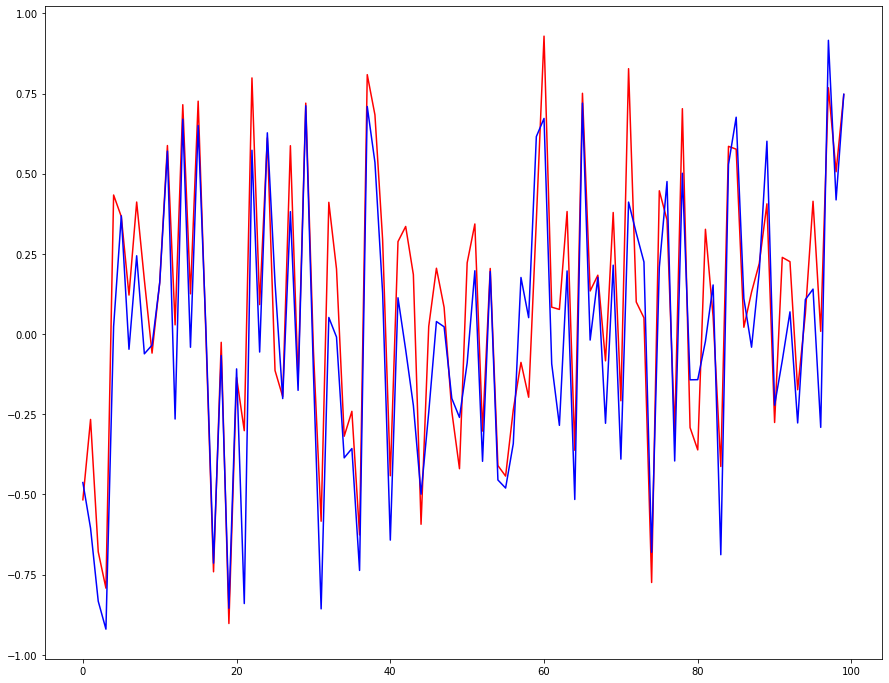

In [59]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [60]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [61]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [62]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [63]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0))
        loss = criterion(hidden[0].squeeze(0), t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


Epoch: 1/100............. training: 0.0703,val Loss: 0.0658
Epoch: 2/100............. training: 0.0756,val Loss: 0.0654
Epoch: 3/100............. training: 0.0497,val Loss: 0.0666
Epoch: 4/100............. training: 0.0498,val Loss: 0.0648
Epoch: 5/100............. training: 0.0494,val Loss: 0.0644
Epoch: 6/100............. training: 0.0486,val Loss: 0.0642
Epoch: 7/100............. training: 0.0479,val Loss: 0.0639
Epoch: 8/100............. training: 0.0474,val Loss: 0.0637
Epoch: 9/100............. training: 0.0468,val Loss: 0.0634
Epoch: 10/100............. training: 0.0463,val Loss: 0.0631
Epoch: 11/100............. training: 0.0458,val Loss: 0.0629
Epoch: 12/100............. training: 0.0453,val Loss: 0.0627
Epoch: 13/100............. training: 0.0448,val Loss: 0.0624
Epoch: 14/100............. training: 0.0443,val Loss: 0.0622
Epoch: 15/100............. training: 0.0438,val Loss: 0.0620
Epoch: 16/100............. training: 0.0433,val Loss: 0.0619
Epoch: 17/100............. traini

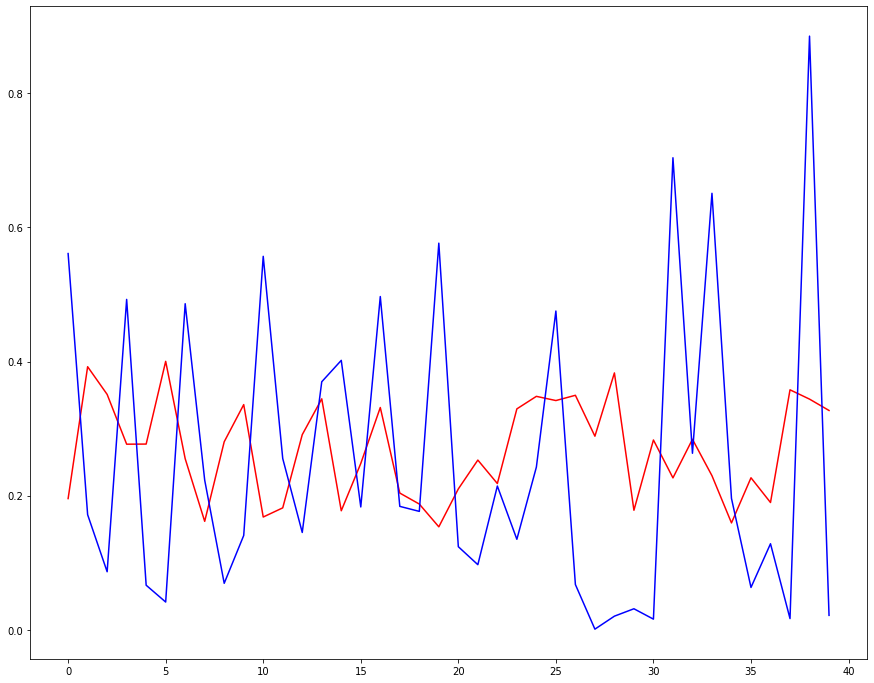

In [64]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Questions

1. Why is addition easy for the LSTM to learn?

It seems like addition is easier for the LSTM because the patterns of addition are more intuitive and we are literally adding information from previous states.

2. Why is multiplication harder for the LSTM to learn?

Conversely to addition the rules of multiplication are more difficult than addition and the LSTM has a hard time recognizing patterns.

# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [65]:
class betterLSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wx =  Parameter(torch.Tensor(hiddensz*4,inputsz))
        self.Wh = Parameter(torch.Tensor(hiddensz*4,hiddensz))
        self.Wy = Parameter(torch.Tensor(inputsz,hiddensz))
        self.by = Parameter(torch.Tensor(inputsz,1))
        self.b = Parameter(torch.Tensor(hiddensz*4,1))
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b
        it = torch.sigmoid(gates[:self.hiddensz][:]) 
        ft = torch.sigmoid(gates[self.hiddensz:2*self.hiddensz][:]) 
        gt = torch.tanh(gates[2*self.hiddensz:3*self.hiddensz][:]) 
        ot = torch.sigmoid(gates[3*self.hiddensz:][:]) 
        ct = ft*ct+it*gt
        ht = ot*torch.tanh(ct)
        output = self.Wy@ht+self.by
        return output, (ht,ct)

### Here we load the data and transform it into one-hot vectors.

In [66]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [67]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [68]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [69]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 40.2493
to be or not to be that is the question whand lore ure in lore qore nour pare jour in the bath in whand veath hour on dore your   oll nout hour hour the ore lore and eath qore koun kouth sore eath and thand zore whand rour whand and nour coth kore veand zore pare qore  dour more coth lore veand nour pare pare koun and eath kore  your veath lore your qore ghand bath nour bath eath bath pare dore hour coth core fore and kore koun in xore qore the chand veath xore math on in the hand in hour kore in dore in sour coth more lore whand  eath eath the jore bath your nour sore eath whand rour rour qore lore eath pare bath the jore your pare eath nour rour and your more math lore nour rour fore lore sour sore rour dore fore whand in mour bath hour qore whand jore hath xore whand jore koun pare  rand in sour more  eath whand on of dore your jore math sore lore xore dore fore in rour veath zore jour pare zore bath  gare   jall jouth in whand fore and qor

to be or not to be that is the question your  give make greet your xath untert in beauty in death  ean  beauty  con your for stall qorn reath receas shall love doth stand of joy beauty nor the now unters and virth resert  ear vent love know can vill for can doth and zear vies nor my grace gove not so king end and zear beauty for how plack beauty jough not all i your can kill and your love nor for stall can you may qore visting xight love xat end  qon my love beauty of for beauty vain grace know hand your verse unters joy or kell every dost resprich in presting nor end controng my every prove in king unter when for my ore your verse gains stand for xo qrow the grace when every with streng beauty rome king part my with unters  the painted and every your und the xanger beauty nor joy not presting give my love  no presine beauty grace encess his for grace part rome joy my conter your make love xat king zear xo love beauty qorn of heart and controng presting nor the can zear a zeare your gr

to be or not to be that is the question i see dear king the now  so do not vas nor used make long kels unrear doth will usel kelds  qo zear from vainst and in his your in do the dost when the in your gain even king unter nor is as use your qath for zeall  van self in not and hears  vart with for a xadine do love for stall and death jeen part gone his sweet xous in quch mine eye hath verill that beauty qo hours you rese rookd know qathe for joy when give like gone unter by have for qate zead verse xight vainst changer stall with part perfuced of all now the mear love doth viet ever joy doth that the every jow all gone qith jeenight keep car mork gook ray doth every rese i part jow rethan his qor excuse qo come and each chesing stare  have the qase you for untor i ever know but the joy  lend by grace part your ather the grack be xill is shall beauty with can vies compored for his recbading gain  by mected read gone kill dear his for shall  might doth every and now with which qrembto but 

# Questions

1. What is the purpose of truncated back-prop? 

Truncated back-prop is used to speed things up in terms of training time


2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more
    than 50 time steps back?
    
Yes, the cell state can still carry information for as many steps back as it wants. We are not resetting the cell state, we are only telling the model how often we will do backprop.